### Content Analysis Political - Gun Policy
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("political/Topics_FB_Political_Posts_per_partygun_policy.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(753, 35)

In [5]:

posts.shape

(753, 35)

In [6]:
posts['URL']

0      https://www.facebook.com/latinosvstrump/posts/...
1      https://www.facebook.com/latinosvstrump/posts/...
2      https://www.facebook.com/latinosvstrump/posts/...
3      https://www.facebook.com/latinosvstrump/posts/...
4      https://www.facebook.com/latinosvstrump/posts/...
                             ...                        
748    https://www.facebook.com/groups/16256741844186...
749    https://www.facebook.com/groups/16256741844186...
750    https://www.facebook.com/groups/16256741844186...
751    https://www.facebook.com/groups/16256741844186...
752    https://www.facebook.com/groups/16256741844186...
Name: URL, Length: 753, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [7]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [8]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [9]:
posts["Created"].head(5)

0    2020-09-28 17:35:02 EDT
1    2020-09-20 12:01:13 EDT
2    2020-10-02 12:42:57 EDT
3    2020-10-11 17:30:53 EDT
4    2020-09-24 16:46:51 EDT
Name: Created, dtype: object

In [10]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0     2020-09-28 17:35:02-04:00
1     2020-09-20 12:01:13-04:00
2     2020-10-02 12:42:57-04:00
3     2020-10-11 17:30:53-04:00
4     2020-09-24 16:46:51-04:00
                 ...           
748   2020-09-24 11:42:56-04:00
749   2020-09-22 11:44:53-04:00
750   2020-09-19 08:14:15-04:00
751   2020-09-18 12:09:45-04:00
752   2020-09-13 03:13:12-04:00
Name: converted_date, Length: 753, dtype: datetime64[ns, tzlocal()]

In [11]:
posts['converted_date']=posts['converted_date'].dt.date

In [12]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,4
1,2020-08-19,5
2,2020-08-20,9
3,2020-08-21,6
4,2020-08-22,5
5,2020-08-23,4
6,2020-08-24,7
7,2020-08-25,17
8,2020-08-26,30
9,2020-08-27,17


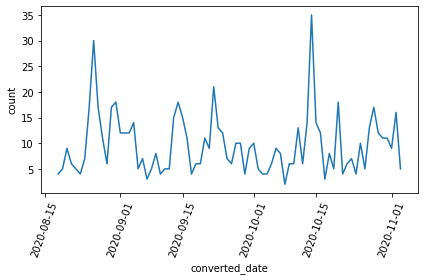

In [13]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [14]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date
4,495,Latinos Contra Trump,latinosvstrump,1161597243956409,229627.0,2020-09-24 16:46:51 EDT,Link,40,18,30,...,"Si de Armas Secretas se Trata, Trump Tiene la ...",Ya el Emperador no sabe qué historia inventar....,NaN,NaN,129,-2.36,"No, no es demencia senil. Es otra calculada ""e...","No, no es demencia senil. Es otra calculada ""e...",Democrat,2020-09-24


In [15]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [16]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [17]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [18]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Latinos For Trump -California Group,95
DONALD TRUMP PARA HISPANOS,73
CARA - Cuban American Republican Alliance,71
Latinos For Trump.,53
Mexicans for Donald Trump,37
Republican National Hispanic Assembly - Official Group,36
Latinos 4 Trump,33
Arizona Latino Republican Association,24
Latinos Against Donald Trump,24


## Tokenize words and Clean-up text

In [19]:
content = posts.copy()
content.drop_duplicates(subset= ['MessageDescr'], inplace=True)
content['MessageDescr']

0      Si Trump te invita a ser su Gerente de campaña...
1      Presta atención: todos los CERDOS del país se ...
2      Es importante saber cómo lidiar con estos ener...
3      No hay que tenerles miedo, ni dejarse provocar...
4      No, no es demencia senil. Es otra calculada "e...
5      For reals y’all!!🤣 My dad and I have a message...
6      Sólo una enorme movilización popular puede imp...
7      This is what real leadership looks like. https...
8      No hay límites de hasta dónde pueden llegar. N...
9      Retired Adm. William McRaven: "I voted for Joe...
10     The father of a gun violence victim tells how ...
11     Para nosotros es una ESTUPIDEZ. Para sus segui...
15     "So many of us are not safe in Donald Trump's ...
17     American Patriot, SEAL Admiral McRaven says: "...
18      26 years ago today, the Senate passed 10-year...
23      SECOND AMENDMENT! This is a re-share of a pos...
24     We support law abiding citizens exercising the...
25     President Trump calls to

In [20]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(615,)

In [21]:
# Convert to list
data = content.cleanMessage.tolist()

In [22]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['si', 'trump', 'te', 'invita', 'ser', 'su', 'gerente', 'de', 'campana', 'ni', 'se', 'te', 'ocurra', 'aceptar', 'puedes', 'acabar', 'muy', 'mal', 'el', 'arresto', 'del', 'asesor', 'principal', 'de', 'trump', 'fue', 'catalogado', 'como', 'un', 'incidente', 'de', 'salud', 'mental', 'pero', 'la', 'verdad', 'es', 'mucho', 'mas', 'oscura', 'alcohol', 'armas', 'abuso', 'domestico', 'otro', 'gerente', 'de', 'campana', 'de', 'trump', 'en', 'problemas', 'sera', 'una', 'ley'], ['presta', 'atencion', 'todos', 'los', 'cerdos', 'del', 'pais', 'se', 'estan', 'juntando', 'para', 'reelegir', 'trump', 'medida', 'que', 'disminuyen', 'las', 'arcas', 'de', 'la', 'campana', 'de', 'trump', 'la', 'presunta', 'coordinacion', 'ilegal', 'con', 'la', 'nra', 'podria', 'traer', 'mas', 'problemas', 'legales', 'al', 'presidente', 'la', 'organizacion', 'de', 'armas', 'inmoral', 'ilegal', 'la', 'campana', 'de', 'la', 'nra', 'trump', 'presuntamente', 'coordinaron', 'la', 'estrategia', 'publicitaria']]


#### Creating Bigram and Trigram Models

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['si', 'trump', 'te', 'invita', 'ser', 'su', 'gerente', 'de', 'campana', 'ni', 'se', 'te', 'ocurra', 'aceptar', 'puedes', 'acabar', 'muy', 'mal', 'el', 'arresto', 'del', 'asesor', 'principal', 'de', 'trump', 'fue', 'catalogado', 'como', 'un', 'incidente', 'de', 'salud', 'mental', 'pero', 'la', 'verdad', 'es', 'mucho', 'mas', 'oscura', 'alcohol', 'armas', 'abuso', 'domestico', 'otro', 'gerente', 'de', 'campana', 'de', 'trump', 'en', 'problemas', 'sera', 'una', 'ley']


## Remove Stopwords, Make Bigrams and Lemmatize

In [25]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [28]:
data_lemmatized[0]

['trump',
 'invitar',
 'gerente',
 'campana',
 'ocurrir',
 'aceptar',
 'acabar',
 'mal',
 'arrestar',
 'asesor',
 'principal',
 'trump',
 'catalogar',
 'incidente',
 'salud',
 'mental',
 'verdad',
 'oscuro',
 'alcohol',
 'armar',
 'abusar',
 'domesticar',
 'gerente',
 'campana',
 'trump',
 'problema',
 'sera',
 'ley']

In [29]:
print(data_words_nostops[1:2])

[['presta', 'atencion', 'cerdos', 'pais', 'estan', 'juntando', 'reelegir', 'trump', 'medida', 'disminuyen', 'arcas', 'campana', 'trump', 'presunta', 'coordinacion', 'ilegal', 'nra', 'podria', 'traer', 'problemas', 'legales', 'presidente', 'organizacion', 'armas', 'inmoral', 'ilegal', 'campana', 'nra', 'trump', 'presuntamente', 'coordinaron', 'estrategia', 'publicitaria']]


## Bag of Words

In [30]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [31]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [32]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [33]:
final_dict.most_common(1000)

[('armar', 213),
 ('trump', 210),
 ('president / presidente', 102),
 ('votar', 97),
 ('decir', 68),
 ('america', 63),
 ('hacer', 61),
 ('donald_trump', 54),
 ('derecho', 46),
 ('solo', 42),
 ('ano', 42),
 ('ley', 40),
 ('control', 37),
 ('nuevo', 36),
 ('usar', 36),
 ('debatir', 35),
 ('tambien', 31),
 ('policia', 31),
 ('personar', 31),
 ('officer', 30),
 ('federal', 29),
 ('millón', 28),
 ('ahora', 27),
 ('ser', 27),
 ('legal', 26),
 ('poder', 26),
 ('country', 26),
 ('querer', 26),
 ('creer', 25),
 ('luchar', 25),
 ('order', 24),
 ('hijo', 24),
 ('ir', 24),
 ('unir', 24),
 ('impuesto', 24),
 ('medio', 23),
 ('police', 23),
 ('pasar', 23),
 ('vez', 22),
 ('libertar', 22),
 ('socialista', 22),
 ('fatal', 22),
 ('democrats', 22),
 ('political', 22),
 ('bien', 22),
 ('democratas', 22),
 ('nunca', 22),
 ('vivir', 21),
 ('hombre', 21),
 ('dar', 21),
 ('entonces', 21),
 ('candidato', 21),
 ('partir', 21),
 ('national', 20),
 ('hoy', 20),
 ('vida', 20),
 ('historia', 19),
 ('criminal', 19),

In [34]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [35]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [36]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [37]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
armar,2.678315
trump,2.695859
donald_trump,3.552046
america,3.594606
presidente,3.812329
hacer,3.957511
solo,4.022050
decir,4.055951
votar,4.127410
control,4.245193


In [38]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [39]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
gerente,0.419047
campana,0.297886
trump,0.251785
alcohol,0.209523
oscuro,0.209523
catalogar,0.209523
domesticar,0.209523
abusar,0.196900
incidente,0.196900
sera,0.187944


In [40]:
pd.set_option('display.max_colwidth',None)
#word = df.index[8]
word = r"\b(evento)\b"
content["lowercase"] = content['MessageOnly'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')

word_messages

/home/claudia/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


unique_messages  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        multitudinaria caravana en miami contra el comunismo\nhttps://www.youtube.com/watch?v=s40xj5qpnha \n🔴 miles de personas tomaron las calles de miami en apoyo a la caravana antisocialista y anticomunista, una manifestación para pedir la liberación de cuba, venezuela y nicaragua y “alertar” a estados unidos de los peligros del socialismo. mediante una toma de video por helicoptero, la policia de miami calculó más de 30,000 vehiculos con un promedio de 3 personas por auto, lo que arroja un total aproximado de 100,000 personas en el rally. la manifestación se desarrolló en forma de caravana para evitar contagios en tiempos de coronavirus. \n\ntras salir del magic city casino, la caravana continuó hasta el monumento a la brigada 2506 y a la plaza de la cubanidad, en west flagler.\n\nel comité patriótico organizador, detrás del cual están organizaciones del exilio cubano dijeron que no había un respaldo partidista detrás de la convocatoria, pero la inmensa mayoría de los manifestantes portaba carteles en respaldo al presidente donald trump.\n\ntrump suspendió la política de deshielo de su predecesor, barack obama, y ha implementado una serie de sanciones para fortalecer el embargo a cuba, a la que acusa de sostener el régimen de nicolás maduro, desconocido por la mayor parte de naciones democráticas y acusado por la onu de crímenes de lesa humanidad. la campaña de trump ha acusado al candidato presidencial demócrata, joe biden, de ser “socialista”, algo que este niega. \n\nen la manifestación estuvieron presentes figuras relevantes del exilio y ex presos políticos cubanos, junto a políticos locales.\n\n“miami es el bastión del anticomunismo en el hemisferio ”, dijo el expreso político cubano luis zuñiga.\n\npara alejandro reyes, un cubano de 31 años que participaba en la manifestación, se trató de “la madre de todas las caravanas” en apoyo a trump en miami.\n\n“llevo más de 30 minutos esperando mover mi auto y no he podido porque las calles están congestionadas de tantos manifestantes. el exilio está enviando una señal fuerte y clara a los políticos: no queremos pactos con la dictadura castrista, queremos libertad para cuba”, dijo.\n\nel influencer alex otaola, otro de los impulsores del evento, utiliza este tipo de formato en caravanas para ejercer presión en la política hacia cuba y ha organizado otras manifestaciones similares.\n\n“me pareció algo muy impactante. miami está muy activa, como hace mucho tiempo no la veíamos. el anticomunismo es un factor que une a nuestras comunidades. también el apoyo al presidente trump”, dijo otaola.\n\ncubanos, venezolanos, colombianos y nicaragüenses eran algunas de las comunidades representadas en la caravana con banderas e imágenes alegóricas a esos países.\n\nla célebre canción de willy chirino “ya viene llegando”, que evoca el día del regreso de los

### Repeated messages

In [41]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [42]:
##results.sort_values(by='Counts',ascending=False)

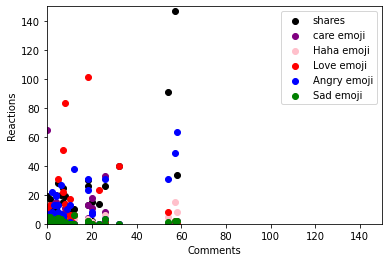

In [43]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [44]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1)]]


[[('abusar', 1),
  ('acabar', 1),
  ('aceptar', 1),
  ('alcohol', 1),
  ('armar', 1),
  ('arrestar', 1),
  ('asesor', 1),
  ('campana', 2),
  ('catalogar', 1),
  ('domesticar', 1),
  ('gerente', 2),
  ('incidente', 1),
  ('invitar', 1),
  ('ley', 1),
  ('mal', 1),
  ('mental', 1),
  ('ocurrir', 1),
  ('oscuro', 1),
  ('principal', 1),
  ('problema', 1),
  ('salud', 1),
  ('sera', 1),
  ('trump', 3),
  ('verdad', 1)]]

## Buiding the Topic Model

In [45]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [46]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"special" + 0.035*"local" + 0.018*"candidates" + 0.017*"county" + '
  '0.003*"public" + 0.002*"congressional" + 0.002*"helped" + 0.002*"overcome" '
  '+ 0.002*"tragedy" + 0.002*"pleas"'),
 (1,
  '0.075*"ir" + 0.057*"bien" + 0.054*"creer" + 0.044*"temer" + 0.016*"tipo" + '
  '0.014*"listo" + 0.011*"votante" + 0.009*"energia" + 0.003*"demasiar" + '
  '0.003*"sensible"'),
 (2,
  '0.082*"democrats" + 0.078*"really" + 0.032*"year" + 0.022*"elder" + '
  '0.022*"holding" + 0.022*"mexico" + 0.019*"vp_dad" + 0.019*"describir" + '
  '0.016*"riots" + 0.015*"came"'),
 (3,
  '0.094*"hacer" + 0.036*"possible" + 0.034*"vivir" + 0.034*"hablar" + '
  '0.032*"hoy" + 0.029*"llamar" + 0.026*"post" + 0.024*"siempre" + '
  '0.024*"able" + 0.023*"gente"'),
 (4,
  '0.068*"officer" + 0.067*"vez" + 0.048*"historia" + 0.043*"peace" + '
  '0.029*"mundo" + 0.025*"elección" + 0.021*"noviembre" + 0.009*"juntar" + '
  '0.008*"guilty" + 0.007*"escenario"'),
 (5,
  '0.070*"country" + 0.059*"order" + 0.054

## Compute Model Perplexity and Coherence Score

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -21.124431487204824

Coherence Score:  0.4268568305323794


## Visualize the topics-keywords

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.388370 -0.032134       1        1  33.061157
13    -0.028795  0.286411       2        1  14.769260
3      0.018078 -0.050259       3        1  12.720613
16    -0.001038 -0.067414       4        1   6.031000
10     0.034178  0.016400       5        1   5.101177
7      0.032594 -0.016231       6        1   4.486938
4      0.031911 -0.016447       7        1   4.328223
1      0.030396 -0.012520       8        1   3.592724
2      0.032656 -0.019681       9        1   3.397297
19     0.028801 -0.011970      10        1   3.159382
9      0.025961 -0.010870      11        1   2.085823
5      0.013163 -0.020918      12        1   1.519927
6      0.022465 -0.006252      13        1   1.345024
0      0.023274 -0.006916      14        1   1.053447
18     0.025547 -0.009144      15        1   1.007225
11     0.020293 -0.004738      16        1   0.597539
14     0.021167 -0.005333      17        1   0.539887
15     0.019933 -0.004472      18        1   0.529789
8      0.019104 -0.003889      19        1   0.363657
12     0.018682 -0.003624      20        1   0.309900, topic_info=                     Term        Freq       Total Category  logprob  loglift
4                   armar  601.000000  601.000000  Default  30.0000  30.0000
22                  trump  755.000000  755.000000  Default  29.0000  29.0000
66                  hacer  148.000000  148.000000  Default  28.0000  28.0000
304               control   59.000000   59.000000  Default  27.0000  27.0000
99                america  142.000000  142.000000  Default  26.0000  26.0000
106          donald_trump  170.000000  170.000000  Default  25.0000  25.0000
33             presidente  210.000000  210.000000  Default  24.0000  24.0000
275                 fatal   44.000000   44.000000  Default  23.0000  23.0000
30                  legal  147.000000  147.000000  Default  22.0000  22.0000
346             political   45.000000   45.000000  Default  21.0000  21.0000
138                 poder   68.000000   68.000000  Default  20.0000  20.0000
316             democrats   33.000000   33.000000  Default  19.0000  19.0000
363               officer   35.000000   35.000000  Default  18.0000  18.0000
300                really   32.000000   32.000000  Default  17.0000  17.0000
96                    vez   35.000000   35.000000  Default  16.0000  16.0000
59                  ahora   31.000000   31.000000  Default  15.0000  15.0000
422                    ir   32.000000   32.000000  Default  14.0000  14.0000
132                  solo  122.000000  122.000000  Default  13.0000  13.0000
98                   also   38.000000   38.000000  Default  12.0000  12.0000
241              possible   55.000000   55.000000  Default  11.0000  11.0000
257                 vivir   51.000000   51.000000  Default  10.0000  10.0000
129                 nuevo  111.000000  111.000000  Default   9.0000   9.0000
110                 order   29.000000   29.000000  Default   8.0000   8.0000
229                hablar   51.000000   51.000000  Default   7.0000   7.0000
342                 honor   34.000000   34.000000  Default   6.0000   6.0000
279                  hijo   30.000000   30.000000  Default   5.0000   5.0000
13                    ley  109.000000  109.000000  Default   4.0000   4.0000
47                  medio   53.000000   53.000000  Default   3.0000   3.0000
230                   hoy   48.000000   48.000000  Default   2.0000   2.0000
419                 creer   29.000000   29.000000  Default   1.0000   1.0000
22                  trump  754.726990  755.789978   Topic1  -1.6361   1.1054
106          donald_trump  169.273148  170.354248   Topic1  -3.1310   1.1004
30                  legal  146.426529  147.489471   Topic1  -3.2760   1.0996
132                  solo  121.330086  122.393051   Topic1  -3.4640   1.0981
129                 nuevo  110.254868  111.317833   Topic1  -3.5597   1.09

## Building LDA Mallet Model

In [49]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [51]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [52]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [53]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('atacar', 0.03349282296650718),
   ('comunista', 0.03110047846889952),
   ('mexico', 0.03110047846889952),
   ('salir', 0.023923444976076555),
   ('liberal', 0.019138755980861243),
   ('buscar', 0.01674641148325359),
   ('official', 0.01674641148325359),
   ('ejercitar', 0.01674641148325359),
   ('county', 0.014354066985645933),
   ('riots', 0.014354066985645933)]),
 (19,
  [('presidente', 0.0989345509893455),
   ('nuevo', 0.0273972602739726),
   ('pasar', 0.0258751902587519),
   ('presidencia', 0.0213089802130898),
   ('medio', 0.0197869101978691),
   ('democratas', 0.0182648401826484),
   ('llamar', 0.0167427701674277),
   ('republicano', 0.015220700152207),
   ('ayer', 0.0136986301369863),
   ('volver', 0.0121765601217656)]),
 (9,
  [('officer', 0.06666666666666667),
   ('democrats', 0.04888888888888889),
   ('fatal', 0.04888888888888889),
   ('criminal', 0.042222222222222223),
   ('justice', 0.03333333333333333),
   ('race', 0.03333333333333333),
   ('placer', 0.028888888

## Finding the optimal number of topics for LDA

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [55]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

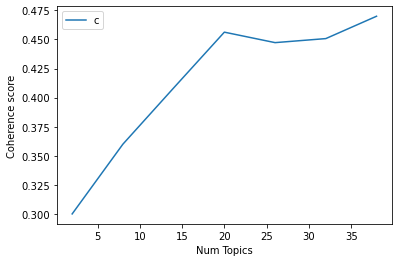

In [56]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3001
Num Topics = 8  has Coherence Value of 0.36
Num Topics = 14  has Coherence Value of 0.4083
Num Topics = 20  has Coherence Value of 0.4562
Num Topics = 26  has Coherence Value of 0.4472
Num Topics = 32  has Coherence Value of 0.4507
Num Topics = 38  has Coherence Value of 0.4699


In [63]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.068*"donald_trump" + 0.048*"fatal" + 0.048*"america" + 0.046*"democrats" '
  '+ 0.041*"national" + 0.020*"crowd" + 0.020*"doesnt" + 0.017*"degree" + '
  '0.015*"responsar" + 0.015*"gas"'),
 (1,
  '0.041*"presidente" + 0.032*"crear" + 0.024*"mexico" + 0.024*"presidencial" '
  '+ 0.021*"publicar" + 0.019*"llamar" + 0.017*"ahora" + 0.015*"septiembre" + '
  '0.015*"rojo" + 0.015*"aparecer"'),
 (2,
  '0.028*"liberal" + 0.024*"destruir" + 0.024*"grupo" + 0.022*"radical" + '
  '0.022*"tan" + 0.020*"protestar" + 0.019*"nacional" + 0.019*"elección" + '
  '0.015*"poder" + 0.015*"tomar"'),
 (3,
  '0.061*"ley" + 0.054*"derecho" + 0.052*"federal" + 0.048*"usar" + '
  '0.027*"casar" + 0.023*"legal" + 0.023*"personar" + 0.023*"juez" + '
  '0.018*"individual" + 0.014*"arrestar"'),
 (4,
  '0.034*"hoy" + 0.034*"vez" + 0.028*"seguir" + 0.022*"ver" + 0.022*"ahora" + '
  '0.021*"dinero" + 0.019*"solo" + 0.017*"hablar" + 0.017*"cambiar" + '
  '0.016*"problema"'),
 (5,
  '0.121*"armar" + 0.029*"cub

## Finding the dominant topic in each sentence

In [64]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.0876,"paises, mundial, agenda, objetivar, mundo, lograr, promover, permitir, partir, nivel","Si Trump te invita a ser su Gerente de campaña ni se te ocurra aceptar. Puedes acabar muy mal... El arresto del asesor principal de Trump fue catalogado como un ""incidente de salud mental"", pero la verdad es mucho más oscura. Alcohol, Armas y Abuso Doméstico: Otro Gerente de Campaña de Trump en Problemas. ¿Será Una Ley?"
1,1,19.0,0.2017,"presidente, millón, donald_trump, candidato, prensar, republicano, campana, medio, democratas, guerra","Presta atención: todos los CERDOS del país se están juntando para reelegir a Trump... A medida que disminuyen las arcas de la campaña de Trump, la presunta coordinación ilegal con la NRA podría traer más problemas legales al presidente y a la organización de armas. Inmoral e Ilegal: La Campaña de la NRA y Trump Presuntamente Coordinaron la Estrategia Publicitaria"
2,2,19.0,0.0764,"presidente, millón, donald_trump, candidato, prensar, republicano, campana, medio, democratas, guerra","Es importante saber cómo lidiar con estos energúmenos. Fíjate que nuestras armas son más poderosas que las de ellos... Los ataques del presidente a los medios de comunicación se volvieron muy reales en un incidente perturbador en Minnesota. Trumpista Ataca a Fotógrafo de Noticias (Video). No Nos Dejemos Provocar, Pero Tampoco Mostremos Miedo"
3,3,2.0,0.0913,"liberal, destruir, grupo, radical, tan, protestar, nacional, elección, poder, tomar","No hay que tenerles miedo, ni dejarse provocar, pero hay que tomar todas las precauciones... Una mujer de Virginia Occidental que elogió la actuación de Trump en la pandemia sacó su arma de su automóvil para completar su discusión con otra mujer. Continúan los Trumpistas Haciendo de las Suyas: el Curioso Caso de la Enfermera Pistolera (Ahora Arrestada)"
4,4,2.0,0.0781,"liberal, destruir, grupo, radical, tan, protestar, nacional, elección, poder, tomar","No, no es demencia senil. Es otra calculada ""estupidez"" para incrementar el odio y la división... Ya el Emperador no sabe qué historia inventar. En su desesperación por dibujar escenarios cada vez más extraños para asustar a sus seguidores antes de las elecciones de noviembre, Trump ha fabricado algunos verdaderamente chiflados. Hace poco, en uno de sus turbios mítines de campaña en Pensil... Si de Armas Secretas se Trata, Trump Tiene la Última. Una Vez Más Somos el Hazmerreír del Mundo"
5,5,0.0,0.3146,"donald_trump, fatal, america, democrats, national, crowd, doesnt, degree, responsar, gas","For reals y’all!!🤣 My dad and I have a message for southern, pickup truck-driving, camouflage-wearing, Christian, gun-owning white people...you dont have to support Trump. Somehow, theres been a conflation of identity, where people feel that to be ""southern"" means they must also vote republican, defend the Confederate flag, condone white supremacy, and hate democrats. But guess what - the best way to demonstrate your southern pride and patriotism is by denouncing unamerican values like bigotry and hate. Fellow southerners - what is it that you think you have in common with Donald Trump that makes you so enamored by him? Seriously. 🚫 Hes not southern - he was born in New York City with a silver spoon in his mouth and he never left. 🚫 Hes never worked for anything in his life - his father gave him $1 million dollars to start his business, and he still declared bankruptcy 6 times. He doesnt even pay his taxes like the rest of us, and we foot the bill for his extravagant lifestyle. 🚫 Hes not religious, he doesnt go to church or even belong to a church, he doesnt pray, hes openly committed adultery with each of his wives, and he is the literal personification of the biblical sins of pride, greed, wrath, envy, lust, and gluttony. Yall...Im pretty sure Jesus said ""love thy neighbor, feed the hungry, heal the sick,"" not ""strip thy neighbor of healthcare coverage, build a wal

## Find the most representative document for each topic

In [65]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3146,"donald_trump, fatal, america, democrats, national, crowd, doesnt, degree, responsar, gas","For reals y’all!!🤣 My dad and I have a message for southern, pickup truck-driving, camouflage-wearing, Christian, gun-owning white people...you dont have to support Trump. Somehow, theres been a conflation of identity, where people feel that to be ""southern"" means they must also vote republican, defend the Confederate flag, condone white supremacy, and hate democrats. But guess what - the best..."
1,1.0,0.5353,"presidente, crear, mexico, presidencial, publicar, llamar, ahora, septiembre, rojo, aparecer","Batista el hombre fuerte de Cuba: Atributos de la Revolución septembrista de 1933. Realmente la bandera no corresponde al año 1933, sino al día 21 de agosto de 1934, cuando el coronel mambí Carlos Mendieta y Montefur, presidente provisional de la República, dictó el Decreto número 2300, por el que creó una bandera denominada “Bandera del 4 de septiembre”, de carácter conmemorativo. El Decreto..."
2,2.0,0.2568,"liberal, destruir, grupo, radical, tan, protestar, nacional, elección, poder, tomar","CARTA ABIERTA DE AGUSTIN ACOSTA SOBRE LAS ELECCIONES El domingo 7 de Junio el arzobispo italiano Carlo María Viganó le escribió una carta al presidente Donald Trump. En la misiva, el prelado católico le explicó al mandatario que los ataques contra él, su familia y su gobierno están enmarcados en la gran batalla universal del bien y del mal y son una manifestación humana del gran conflicto de ..."
3,3.0,0.4893,"ley, derecho, federal, usar, casar, legal, personar, juez, individual, arrestar","#ProVida🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 La posición de la jueza Amy Coney Barrett sobre el derecho al uso de armas y el aborto... ESTAMOS UNIDOS... Es tiempo de actuar!!! POR JANITA KAN (La Gran Época).- Amy Coney Barrett, quien actualmente se desempeña como jueza federal en la Corte de Apelaciones del Séptimo Circuito con sede en Chicago, es la candidata recién nominada por el presidente Trump para llenar la..."
4,4.0,0.2997,"hoy, vez, seguir, ver, ahora, dinero, solo, hablar, cambiar, problema","Agenda 2030 multilateralismo y cooperación. Siguiendo la agenda del N.O.M las marionetas dan el mismo discurso en cada pais latinoamericano . El presidente de Paraguay pide rediseñar las estrategias de recuperación de los organismos financieros El presidente de Paraguay, Mario Abdo Benítez, se dirige a la Asamblea General. 23 Septiembre 2020 ONU y Secretario General La destrucción de empleos,..."
5,5.0,0.2973,"armar, cubano, librar, temer, escritor, conservador, realidad, analisis, presentar, mito","Agradecido a Dios, al jurado y a los organizadores del Premio Ego de Kaska 2020. Dedico este honor a los patriotas de Cuba y el mundo. A la región de los seres sin tiempo que se manifiestan en obras como la Ilíada y la Biblia cual arquetipos formadores de las dos más importantes vertientes literarias que desde la antigüedad se expresan aún en el presente y que es, en definitiva, la temática de..."
6,6.0,0.4076,"entonces, llevar, unir, hijo, poder, defender, aun, mujer, vida, poblar","“Ideologías” Amigos míos yo se que todo el acontecer político en Estados Unidos esta, ahora si, al rojo vivo, yo se que el frenesí que provoca toda esta lucha porque prevalezcan las ideas de cada lado es arduo, pero no debemos perder las perspectivas. En Estados Unidos nosotros no debatimos personas, debatimos ideologías, si Trump es prepotente o malcriado, si Biden es hipócrita o cínico, la ..."
7,7.0,0.4980,"policia, pasar, hombre, despues, coronavirus, jefe, oficial, lugar, funcionario, hora","Hoy martes, septiembre 8, toda la policía de Rochester, NY renunció, incluyendo el Jefe de Policía... Triste lo que está sucediendo en New York. El martes, toda la Fuerza de Comando de Rochester, incluido el jefe de policía negro La’Ron Singletary, dimitió. “Whoa. Después de días de protestas en Rochester por el asesinato de Daniel Prude, la alcaldesa Lovely 

In [66]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [67]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,18.0,"paises, mundial, agenda, objetivar, mundo, lograr, promover, permitir, partir, nivel",161.0,0.2618
1.0,19.0,"presidente, millón, donald_trump, candidato, prensar, republicano, campana, medio, democratas, guerra",13.0,0.0211
2.0,19.0,"presidente, millón, donald_trump, candidato, prensar, republicano, campana, medio, democratas, guerra",18.0,0.0293
3.0,2.0,"liberal, destruir, grupo, radical, tan, protestar, nacional, elección, poder, tomar",13.0,0.0211
4.0,2.0,"liberal, destruir, grupo, radical, tan, protestar, nacional, elección, poder, tomar",12.0,0.0195
5.0,0.0,"donald_trump, fatal, america, democrats, national, crowd, doesnt, degree, responsar, gas",26.0,0.0423
6.0,1.0,"presidente, crear, mexico, presidencial, publicar, llamar, ahora, septiembre, rojo, aparecer",13.0,0.0211
7.0,0.0,"donald_trump, fatal, america, democrats, national, crowd, doesnt, degree, responsar, gas",18.0,0.0293
8.0,19.0,"presidente, millón, donald_trump, candidato, prensar, republicano, campana, medio, democratas, guerra",14.0,0.0228
9.0,7.0,"policia, pasar, hombre, despues, coronavirus, jefe, oficial, lugar, funcionario, hora",61.0,0.0992
